# Photonic kernels

- Generate a dataset using the chip with $n$ photons
- Learn the dataset using $k \leq n$ photons
- Compare performance with standard Gaussian kernels

### Code to construct chips

In [1]:
from discopy.quantum.optics import MZI, BeamSplitter, PhaseShift, Id

def params_shape(width, depth):
    """ Returns the shape of parameters given width and depth. """
    even_width = not width % 2
    even_depth = not depth % 2
    if even_width:
        if even_depth:
            # we have width // 2 MZIs on the first row
            # followed by width // 2 - 1 equals width - 1
            return (depth // 2, width - 1, 2)
        else:
            # we have the parameters for even depths plus
            # a last layer of width // 2 MZIs
            return (depth // 2 * (width - 1) + width // 2, 2)
    else:
        # we have width // 2 MZIs on each row, where
        # the even layers are tensored by Id on the right
        # and the odd layers are tensored on the left.
        return (depth, width // 2, 2)


def ansatz(width, depth, x):
        """ Returns the chip given width, depth and parameters x"""
        params = x.reshape(params_shape(width, depth))
        chip = Id(width)
        if not width % 2:
            if depth % 2:
                params, last_layer = params[:-width // 2].reshape(
                    params_shape(width, depth - 1)), params[-width // 2:]
            for i in range(depth // 2):
                chip = chip\
                    >> Id().tensor(*[
                        MZI(*params[i, j])
                        for j in range(width // 2)])\
                    >> Id(1) @ Id().tensor(*[
                        MZI(*params[i, j + width // 2])
                        for j in range(width // 2 - 1)]) @ Id(1)
            if depth % 2:
                chip = chip >> Id().tensor(*[
                    MZI(*last_layer[j]) for j in range(width // 2)])
        else:
            for i in range(depth):
                left, right = (Id(1), Id()) if i % 2 else (Id(), Id(1))
                chip >>= left.tensor(*[
                    MZI(*params[i, j])
                    for j in range(width // 2)]) @ right
        return chip

### Initialise width and depth of chip

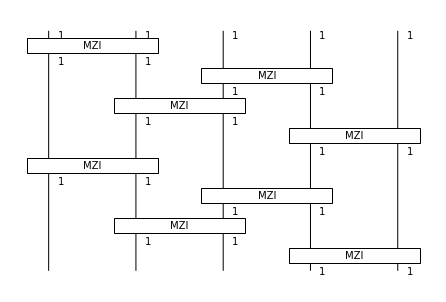

In [2]:
import numpy as np

depth = 4
width = 5
n_params = 2 * (depth * width // 2 - depth // 2)

random_datapoint = lambda: np.random.uniform(0, 2, size=(n_params,))

x0 = random_datapoint()
ansatz(width, depth, x0).draw()

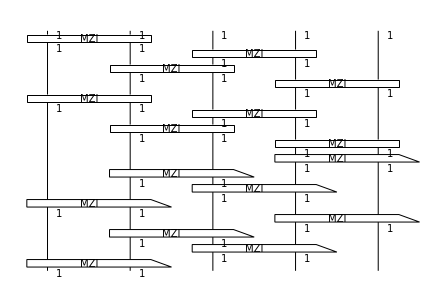

In [3]:
(ansatz(width, depth, x0) >> ansatz(width, depth, x0).dagger()).draw()

### Generate the dataset

In [4]:
from discopy.quantum.optics import occupation_numbers

n_photons = 3
a = [0, 1, 1, 1, 0]

def label(x):
    ''' Returns label of datapoint x, obtained by sampling from the chip with input state a'''
    basis_states = occupation_numbers(n_photons, width)
    chip = ansatz(width, depth, x)
    p_left = sum([np.absolute(chip.amp(a, b)) ** 2 for b in basis_states[:len(basis_states) // 2]])
    if p_left > .5:
        return 1
    else:
        return -1      

In [5]:
D = 120 # number of datapoints, must be even.

data = []
labels =[]
count_positive, count_negative, count_discarded = 0, 0, 0

while count_negative + count_positive < D:
        x = random_datapoint()
        y = label(x)
        if y == -1 and count_negative < D // 2:
            data += [x]
            labels += [y]
            count_negative += 1
        elif y == 1 and count_positive < D // 2:
            data += [x]
            labels += [y]
            count_positive += 1
        else:
            count_discarded += 1
        print('Number of positive samples: {}, Number of negative samples: {}'.format(
                count_positive, count_negative), end='\r')

assert sum(labels) == 0 
print('\nNumber of discarded samples: {}'.format(count_discarded))

Number of positive samples: 60, Number of negative samples: 60
Number of discarded samples: 19


### Learn dataset with photonic kernel

In [6]:
photonic_kernel = lambda state: lambda x0, x1: np.absolute(
                        (ansatz(width, depth, x0) >> ansatz(width, depth, x1).dagger()).amp(state, state)) ** 2

photonic_kernel(a)(data[4], data[4])

0.9999999999999993

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=1/4, random_state=115)
sum(y_train)

2

In [8]:
from sklearn import svm
from sklearn.metrics import classification_report

classifier = svm.SVC(kernel='precomputed', verbose=True)

state = [0, 1, 1, 1, 0]

gram_train = np.array([[photonic_kernel(state)(x0, x1) for x1 in X_train] for x0 in X_train])
classifier.fit(gram_train, y_train)

print('Performance on TRAIN data:')
print(classification_report(y_train, classifier.predict(gram_train)))

[LibSVM]Performance on TRAIN data:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        46

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



In [9]:
gram_test = [[photonic_kernel(state)(x0, x1) for x1 in X_train] for x0 in X_test] 
print('Performance on TEST data:')
print(classification_report(y_test, classifier.predict(gram_test)))


Performance on TEST data:
              precision    recall  f1-score   support

          -1       0.80      0.50      0.62        16
           1       0.60      0.86      0.71        14

    accuracy                           0.67        30
   macro avg       0.70      0.68      0.66        30
weighted avg       0.71      0.67      0.66        30



### Learn dataset with less photons

In [10]:
state = [0, 1, 0, 1, 0]

gram_train = np.array([[photonic_kernel(state)(x0, x1) for x1 in X_train] for x0 in X_train])
classifier.fit(gram_train, y_train)

print('Performance on TRAIN data:')
print(classification_report(y_train, classifier.predict(gram_train)))

gram_test = [[photonic_kernel(state)(x0, x1) for x1 in X_train] for x0 in X_test] 

print('Performance on TEST data:')
print(classification_report(y_test, classifier.predict(gram_test)))

[LibSVM]Performance on TRAIN data:
              precision    recall  f1-score   support

          -1       1.00      0.98      0.99        44
           1       0.98      1.00      0.99        46

    accuracy                           0.99        90
   macro avg       0.99      0.99      0.99        90
weighted avg       0.99      0.99      0.99        90

Performance on TEST data:
              precision    recall  f1-score   support

          -1       0.60      0.56      0.58        16
           1       0.53      0.57      0.55        14

    accuracy                           0.57        30
   macro avg       0.57      0.57      0.57        30
weighted avg       0.57      0.57      0.57        30



In [11]:
state = [0, 0, 1, 0, 0]

gram_train = np.array([[photonic_kernel(state)(x0, x1) for x1 in X_train] for x0 in X_train])
classifier.fit(gram_train, y_train)

print('Performance on TRAIN data:')
print(classification_report(y_train, classifier.predict(gram_train)))

gram_test = [[photonic_kernel(state)(x0, x1) for x1 in X_train] for x0 in X_test] 

print('Performance on TEST data:')
print(classification_report(y_test, classifier.predict(gram_test)))

[LibSVM]Performance on TRAIN data:
              precision    recall  f1-score   support

          -1       0.74      0.70      0.72        44
           1       0.73      0.76      0.74        46

    accuracy                           0.73        90
   macro avg       0.73      0.73      0.73        90
weighted avg       0.73      0.73      0.73        90

Performance on TEST data:
              precision    recall  f1-score   support

          -1       0.45      0.31      0.37        16
           1       0.42      0.57      0.48        14

    accuracy                           0.43        30
   macro avg       0.44      0.44      0.43        30
weighted avg       0.44      0.43      0.42        30



### Learn with distinguishable photons

In [12]:
dist_photons_kernel = lambda state: lambda x0, x1: (
        ansatz(width, depth, x0) >> ansatz(width, depth, x1).dagger()).amp_dist(state, state)

state = [0, 1, 1, 1, 0]

gram_train = np.array([[dist_photons_kernel(state)(x0, x1) for x1 in X_train] for x0 in X_train])
classifier.fit(gram_train, y_train)

print('Performance on TRAIN data:')
print(classification_report(y_train, classifier.predict(gram_train)))

gram_test = [[dist_photons_kernel(state)(x0, x1) for x1 in X_train] for x0 in X_test] 

print('Performance on TEST data:')
print(classification_report(y_test, classifier.predict(gram_test)))

[LibSVM]Performance on TRAIN data:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        44

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90

Performance on TEST data:
              precision    recall  f1-score   support

          -1       0.92      0.86      0.89        14
           1       0.88      0.94      0.91        16

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



### Compare with Gaussian kernels

In [13]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

C_range = np.logspace(-2, 2, 50)
gamma_range = np.logspace(-9, 2, 50)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)

/Users/giovannidefelice/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/giovannidefelice/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, ...,
       6.86648845e+01, 8.28642773e+01, 1.00000000e+02]),
                         'gamma': array([1.00000000e-09, 1.67683294e-09, 2.81176870e-09, ...,
       3.55648031e+01, 5.96362332e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [14]:
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 3.3932217718953264, 'gamma': 0.12067926406393265} with a score of 0.62


In [15]:
print('Performance on TRAIN data:')
print(classification_report(y_train, grid.predict(X_train)))

Performance on TRAIN data:
              precision    recall  f1-score   support

          -1       0.94      1.00      0.97        46
           1       1.00      0.93      0.96        44

    accuracy                           0.97        90
   macro avg       0.97      0.97      0.97        90
weighted avg       0.97      0.97      0.97        90



In [16]:
print('Performance on TEST data:')
print(classification_report(y_test, grid.predict(X_test)))

Performance on TEST data:
              precision    recall  f1-score   support

          -1       0.47      0.57      0.52        14
           1       0.54      0.44      0.48        16

    accuracy                           0.50        30
   macro avg       0.50      0.50      0.50        30
weighted avg       0.51      0.50      0.50        30



In [ ]:
# import pickle
# pickle_out = open('dataset-D120-w5-d4-01110.pickle',"wb")
# pickle.dump(data, pickle_out)
# pickle_out.close()